In [1]:
from model import load_model
from image_utils import imagenet_utils
import cv2 ,matplotlib.pyplot as plt

In [2]:
orig_img,img=imagenet_utils.load_test_img()

In [3]:
img.shape

(1, 224, 224, 3)

In [4]:
test=load_model('VGG16')

In [5]:
model=test.model
input_dim=test.input_dim
layer_name='block5_conv3'

In [6]:
from explanation_models import gradcam,gradcam_robust

In [7]:
g= gradcam(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
heatmap_colormap,overlayed_img=g.overlay_heatmap(orig_img,heatmap)

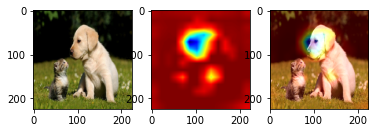

In [8]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

In [9]:
layers=['block5_conv1','block5_conv2','block5_conv3']
g_robust= gradcam_robust(model,layers,input_dim)
heatmap=g_robust.get_heatmap(img)
final=(heatmap[0]+heatmap[1]+heatmap[2])/3.0
heatmap_colormap,overlayed_img=g_robust.overlay_heatmap(orig_img,final)

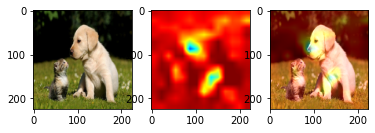

In [10]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

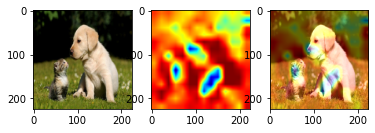

In [17]:
import tensorflow as tf
final=tf.math.maximum(heatmap[0],heatmap[1],heatmap[2])
heatmap_colormap,overlayed_img=g_robust.overlay_heatmap(orig_img,final)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)